## CS441: Applied ML - HW 5

# Part 1: Applications of AI
Nothing to code for this part.

# Part 2: Fine-Tune for Pets Image Classification
Include all the code for Part 2 in this section

## 2.1 Prepare Data

In [1]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lrs
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from pathlib import Path
import numpy as np

In [2]:
# Mount and define data dir
# from google.colab import drive
# drive.mount('/content/drive')
datadir = "./data/"
save_dir = "./"  # change to your directory

In [3]:
def load_pet_dataset(train_transform = None, test_transform = None):
    OxfordIIITPet = datasets.OxfordIIITPet
    if os.path.isdir(datadir+ "oxford-iiit-pet"):
      do_download = False
    else:
      do_download = True
    training_set = OxfordIIITPet(root = datadir,
                             split = 'trainval',
                             transform = train_transform,
                             download = do_download)

    test_set = OxfordIIITPet(root = datadir,
                           split = 'test',
                           transform = test_transform,
                           download = do_download)
    return training_set, test_set


Label: Abyssinian


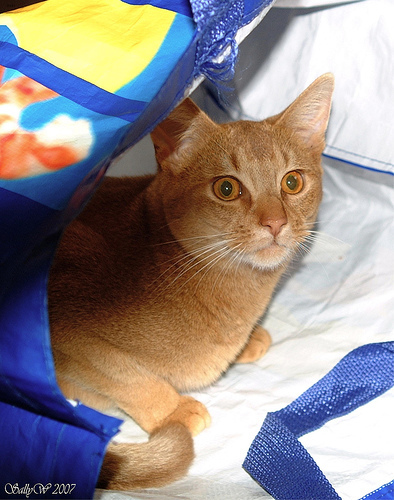

In [4]:
train_set, test_set = load_pet_dataset()

# Display a sample in OxfordIIIPet dataset
sample_idx = 0 # Choose an image index that you want to display
print("Label:", train_set.classes[train_set[sample_idx][1]])
train_set[sample_idx][0]

## 2.2 Data Preprocess

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
# Feel free to add augmentation choices

# Apply data augmentation
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(20),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

test_transform = transforms.Compose([
            transforms.Resize(224),  # resize to 224x224 because that's the size of ImageNet images
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

In [7]:
# Feel free to change
train_set, test_set = load_pet_dataset(train_transform, test_transform)
train_loader = DataLoader(dataset=train_set,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_set,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)


## 2.3 Helper Functions



In [8]:
# Display the number of parameters and model structure
def display_model(model):
  # Check number of parameters
  summary_dict = {}
  num_params = 0
  summary_str = ['='*80]

  for module_name, module in model.named_children():
      summary_count = 0
      for name, param in module.named_parameters():
          if(param.requires_grad):
              summary_count += param.numel()
              num_params += param.numel()
      summary_dict[module_name] = [summary_count]
      summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

  summary_dict['total'] = [num_params]

  # print summary string
  summary_str += ['='*80]
  summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
  print('\n'.join(summary_str))

  # print model structure
  print(model)

In [9]:
# Plot loss or accuracy
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Accuracy Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

## 2.4 YOUR TASK: Fine-Tune Pre-trained Network on Pets
Read and understand the code and then uncomment it.  Then, set up your learning rate, learning scheduler, and train/evaluate. Adjust as necessary to reach target performance.



In [10]:
# set device, using GPU 'cuda' will be faster
device = 'cuda'

In [11]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:

        # TO DO: read/understand these lines and then uncomment the code below

        images, labels = images.to(device), labels.to(device)

        # zero the gradient
        optimizer.zero_grad()

        # predict labels
        prediction = model(images)

        # compute loss
        loss = criterion(prediction, labels)

        # set text to display
        it_train.set_description(f'loss: {loss:.3f}')

        # compute gradients
        loss.backward()

        # update weights
        optimizer.step()

        # keep track of losses
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:

      # TO DO: read/understand and then uncomment these lines

      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
       output = model(images) # do not compute gradient when performing prediction
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)

    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))

    return mean_accuracy, test_loss

In [12]:
# loads a pre-trained ResNet-34 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
num_target_classes = 37

# TO DO: replace the last layer (classification head) with a new linear layer for Pets classification here
model.fc = nn.Linear(512,num_target_classes)

model = model.to(device)
display_model(model) # displays the model structure and parameter count


Using cache found in /home/matty/.cache/torch/hub/pytorch_vision_v0.10.0
/home/matty/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matty/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- conv1                                    :                9408               
- bn1                                      :                128                
- relu                                     :                 0                 
- maxpool                                  :                 0                 
- layer1                                   :               221952              
- layer2                                   :              1116416              
- layer3                                   :              6822400              
- layer4                                   :              13114368             
- avgpool                                  :                 0                 
- fc                                       :               18981               
--Total                                    :          21303653 params          --
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(6

In [13]:
# Training Setting. Feel free to change.
num_epochs = 10
test_interval = 1

# TO DO: set initial learning rate
learn_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

# TO DO: define your learning rate scheduler, e.g. StepLR
# https://pytorch.org/docs/stable/optim.html#module-torch.optim.lr_scheduler
lr_scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 5) 

criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []


# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):

    # Train the network for one epoch
    train_loss = train(train_loader, model, criterion, optimizer)

    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    lr_scheduler.step()

    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    # Get the train accuracy and test loss/accuracy
    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        print('Evaluating Network')

        train_accuracy, _ = test(train_loader, model, criterion) # Get training accuracy
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss = test(test_loader, model, criterion) # Get testing accuracy and error
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        print(f'Test (val) accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')

        # Checkpoints are used to save the model with best validation accuracy
        if test_accuracy >= max(test_accuracy_list):
          print("Saving Model")
          save_checkpoint(save_dir, model, save_name = 'best_model.pth') # Save model with best performance


loss: 0.484: 100%|██████████| 58/58 [00:27<00:00,  2.13it/s]

Loss for Training on epoch 0 is 1.365126132965088 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.20it/s]

Mean Accuracy: 0.9315
Avg loss: 0.3864872368245289
Training accuracy on epoch 0 is 0.9315217391304348 




Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.86it/s]


Mean Accuracy: 0.8760
Avg loss: 0.5534310168747244
Test (val) accuracy on epoch 0 is 0.8759880076315072 

Saving Model


loss: 0.283: 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]

Loss for Training on epoch 1 is 0.32729217410087585 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]

Mean Accuracy: 0.9655
Avg loss: 0.17460602226442304
Training accuracy on epoch 1 is 0.9654891304347826 




Validating ...: 100%|██████████| 58/58 [00:19<00:00,  2.96it/s]


Mean Accuracy: 0.8869
Avg loss: 0.42334816720465135
Test (val) accuracy on epoch 1 is 0.8868901608067593 

Saving Model


loss: 0.218: 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]

Loss for Training on epoch 2 is 0.158196821808815 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]

Mean Accuracy: 0.9853
Avg loss: 0.08267318168333893
Training accuracy on epoch 2 is 0.9853260869565217 




Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Mean Accuracy: 0.8981
Avg loss: 0.3679056157325876
Test (val) accuracy on epoch 2 is 0.8980648678113927 

Saving Model


loss: 0.097: 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]

Loss for Training on epoch 3 is 0.09345895797014236 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.14it/s]

Mean Accuracy: 0.9918
Avg loss: 0.0526671943993404
Training accuracy on epoch 3 is 0.9918478260869565 




Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.13it/s]


Mean Accuracy: 0.8907
Avg loss: 0.3726503958219084
Test (val) accuracy on epoch 3 is 0.8907059144180975 



loss: 0.040: 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]

Loss for Training on epoch 4 is 0.07385122030973434 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.16it/s]

Mean Accuracy: 0.9899
Avg loss: 0.047240411381012405
Training accuracy on epoch 4 is 0.9899456521739131 




Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]


Mean Accuracy: 0.8820
Avg loss: 0.3917609508438357
Test (val) accuracy on epoch 4 is 0.8819841918778959 



loss: 0.021: 100%|██████████| 58/58 [00:24<00:00,  2.39it/s]

Loss for Training on epoch 5 is 0.043226759880781174 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.13it/s]

Mean Accuracy: 0.9984
Avg loss: 0.019384151244343353
Training accuracy on epoch 5 is 0.9983695652173913 




Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]


Mean Accuracy: 0.9106
Avg loss: 0.3275855388492346
Test (val) accuracy on epoch 5 is 0.9106023439629327 

Saving Model


loss: 0.033: 100%|██████████| 58/58 [00:24<00:00,  2.39it/s]

Loss for Training on epoch 6 is 0.035637978464365005 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.15it/s]

Mean Accuracy: 0.9997
Avg loss: 0.01506866529134327
Training accuracy on epoch 6 is 0.9997282608695652 




Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.16it/s]


Mean Accuracy: 0.9106
Avg loss: 0.3126502723015588
Test (val) accuracy on epoch 6 is 0.9106023439629327 

Saving Model


loss: 0.067: 100%|██████████| 58/58 [00:24<00:00,  2.39it/s]

Loss for Training on epoch 7 is 0.027962449938058853 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.11it/s]

Mean Accuracy: 0.9992
Avg loss: 0.013967081149718884
Training accuracy on epoch 7 is 0.9991847826086957 




Validating ...: 100%|██████████| 58/58 [00:19<00:00,  3.03it/s]


Mean Accuracy: 0.9128
Avg loss: 0.30155777398111494
Test (val) accuracy on epoch 7 is 0.9127827745979831 

Saving Model


loss: 0.070: 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]

Loss for Training on epoch 8 is 0.026083189994096756 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.14it/s]

Mean Accuracy: 1.0000
Avg loss: 0.011103250335195455
Training accuracy on epoch 8 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.19it/s]


Mean Accuracy: 0.9117
Avg loss: 0.3057939671943414
Test (val) accuracy on epoch 8 is 0.9116925592804579 



loss: 0.044: 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]

Loss for Training on epoch 9 is 0.02341042459011078 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.16it/s]

Mean Accuracy: 0.9997
Avg loss: 0.010700011192339248
Training accuracy on epoch 9 is 0.9997282608695652 




Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]


Mean Accuracy: 0.9141
Avg loss: 0.3034381479474491
Test (val) accuracy on epoch 9 is 0.9141455437448897 

Saving Model


Training ...: 100%|██████████| 10/10 [10:22<00:00, 62.23s/it]


## 2.5 Plotting of losses and accuracy

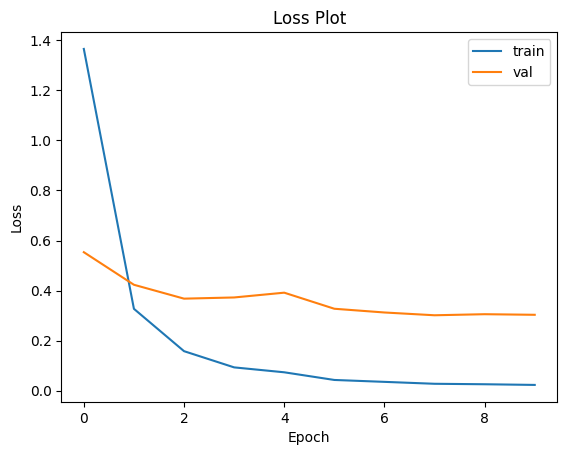

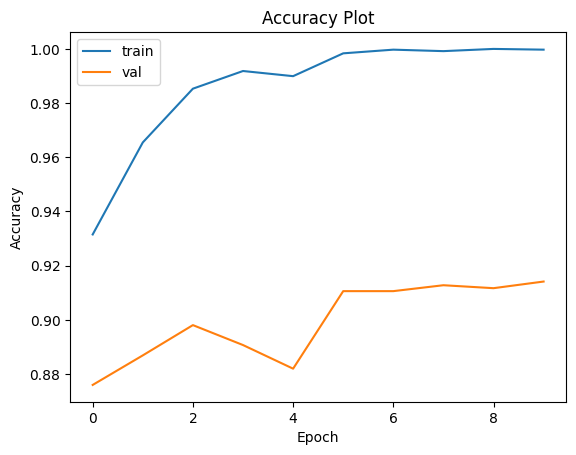

In [14]:
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

## 2.6 Evaluating trained model

In [15]:
# TO DO: initialize your trained model as you did before so that you can load the parameters into it

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model.fc = nn.Linear(512,37)
model.to(device)
# replace last layer

load_model(model, save_dir) # Load the trained weight

test_accuracy, test_loss= test(test_loader, model, criterion)
print(f"Validation accuracy is {str(test_accuracy)} \n")

Using cache found in /home/matty/.cache/torch/hub/pytorch_vision_v0.10.0
Validating ...: 100%|██████████| 58/58 [00:18<00:00,  3.06it/s]

Mean Accuracy: 0.9141
Avg loss: 0.3034381479474491
Validation accuracy is 0.9141455437448897 



# Part 3: CLIP: Contrastive Language-Image Pretraining
Include all the code for Part 3 in this section

### 3.1 Prepare data

[Here](https://drive.google.com/file/d/1zJ1KfymSfsbmD6QS-F0eUC8T1PkqW0_j/view?usp=sharing) is the json file you need for labels of flowers 102

In [3]:
import json
import os
import os.path as osp
import numpy as np
# from google.colab import drive
import torch
from torchvision.datasets import Flowers102
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
# drive.mount('/content/drive')
#datadir = "/content/drive/My Drive/CS441/24SP/hw5/"  # if you copy the json to Google Drive, you'll just have to load the images once
datadir = "./data"


In [9]:
def load_flower_data(img_transform=None):
    if os.path.isdir(datadir+ "flowers-102"):
      do_download = False
    else:
      do_download = True
    train_set = Flowers102(root=datadir, split='train', transform=img_transform, download=do_download)
    test_set = Flowers102(root=datadir, split='val', transform=img_transform, download=do_download)
    classes = json.load(open(osp.join(datadir, "flowers102_classes.json")))

    return train_set, test_set, classes

In [10]:
# READ ME!  This takes some time (a few minutes), so if you are using Colabs and want to use GPU for speed,
#           first set to use GPU: Edit->Notebook Settings->Hardware Accelerator=GPU, and restart instance

# Data structure details
#   flower_train[n][0] is the nth train image
#   flower_train[n][1] is the nth train label
#   flower_test[n][0] is the nth test image
#   flower_test[n][1] is the nth test label
#   flower_classes[k] is the name of the kth class
flower_train, flower_test, flower_classes = load_flower_data()

In [13]:
len(flower_train), len(flower_test)  # output should be (1020, 1020)

(1020, 1020)

Label: pink primrose


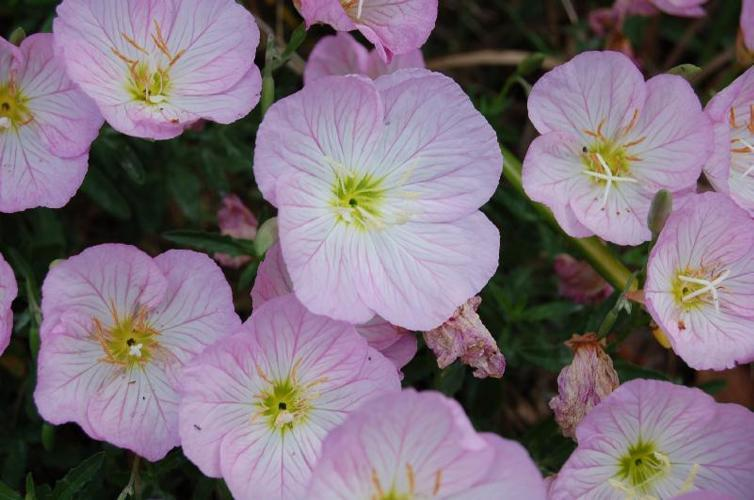

In [14]:
# Display a sample in Flowers 102 dataset
sample_idx = 0 # Choose an image index that you want to display
print("Label:", flower_classes[flower_train[sample_idx][1]])
flower_train[sample_idx][0]

### 3.2 Prepare CLIP model

In [ ]:
# !pip install git+https://github.com/openai/CLIP.git

In [5]:
import clip

In [6]:
# Sets device to "cuda" if a GPU is available
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)
# If this takes a really long time, stop and then restart the download
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

cuda


### 3.3 CLIP zero-shot prediction

Ground truth: snapdragon

Top predictions:

       sweet pea: 30.71%
    garden phlox: 26.27%
      snapdragon: 25.88%
      wallflower: 4.16%
   bougainvillea: 1.90%


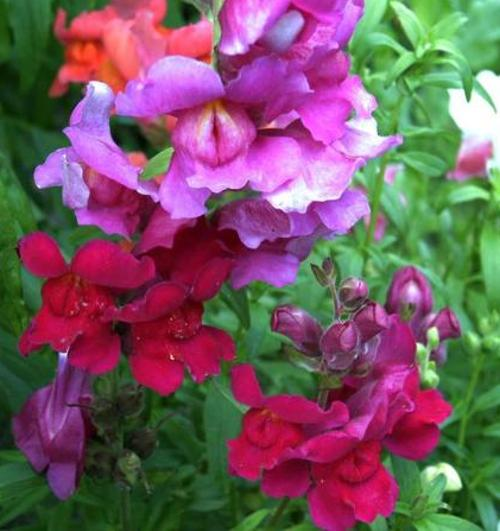

In [21]:
"""The following is an example of using CLIP pre-trained model for zero-shot prediction task"""
# Prepare the inputs
n = 100  # image index to use
image, class_id = flower_train[n]
image_input = clip_preprocess(image).unsqueeze(0).to(device) # extract image and put in device memory
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of flower.") for c in flower_classes]).to(device) # put text to match to image in device memory

# Calculate features
with torch.no_grad():
    image_features = clip_model.encode_image(image_input) # compute image features with CLIP model
    text_features = clip_model.encode_text(text_inputs) # compute text features with CLIP model
image_features /= image_features.norm(dim=-1, keepdim=True) # unit-normalize image features
text_features /= text_features.norm(dim=-1, keepdim=True) # unit-normalize text features

# Pick the top 5 most similar labels for the image
similarity = (100.0 * image_features @ text_features.T) # score is cosine similarity times 100
p_class_given_image= similarity.softmax(dim=-1)  # P(y|x) is score through softmax
values, indices = p_class_given_image[0].topk(5) # gets the top 5 labels

# Print the probability of the top five labels
print("Ground truth:", flower_classes[class_id])
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{flower_classes[index]:>16s}: {100 * value.item():.2f}%")
image

### 3.4 YOUR TASK: Test CLIP zero-shot performance on Flowers 102

 Use pre-trained text and image representations to classify images. For zero-shot recognition, text features are computed from the CLIP model for phrases such as  “An image of [flower_name], a type of flower” for varying [flower_name] inserts. Then, image features are computed using the CLIP model for an image, and the cosine similarity between each text and image is computed. The label corresponding to the most similar text is assigned to the image. You'll get that working using a data loader, which enables faster batch processing; then, compute the accuracy over the test set.  You should see top-1 accuracy in the 60-70% range.

 For zero-shot, you do not use the training set at all.   You should only have to compute the text vectors once and re-use them for all test images.

 Basic steps:

 1. Create the normalized CLIP text vectors for each class label.
 2. For each batch:
       * Create normalized CLIP image vectors
       * Compute similarity between text and image vectors
       * Get index of most likely class label and check whether it matches the ground truth
       * Keep a count of number correct and number total
 3. Return accuracy = # correct / # total  


In [7]:
from tqdm import tqdm
from torch.utils.data import DataLoader

In [11]:
# Load flowers dataset again. This time, with clip_preprocess as transform (you don't have to call clip_preprocess again)
flower_train_trans, flower_test_trans, flower_classes = load_flower_data(img_transform=clip_preprocess)

In [54]:
def clip_zero_shot(data_set, classes):
    data_loader = DataLoader(data_set, batch_size=32, shuffle=False)  # dataloader lets you process in batch which is way faster (when using GPU)
    
    # text features
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of flower.") for c in classes]).to(device) # put text to match to image in device memory
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True) # unit-normalize text features

    accs = []

    for X,Y in data_loader:
        X = X.to(device)
        # print(X.shape)
        # print(Y.shape)
        
        # Calculate features
        with torch.no_grad():
            image_features = clip_model.encode_image(X) # compute image features with CLIP model

        image_features /= image_features.norm(dim=-1, keepdim=True) # unit-normalize image features
        
        # Pick the top 5 most similar labels for the image
        similarity = (100.0 * image_features @ text_features.T) # score is cosine similarity times 100
        pred = similarity.argmax(dim=-1).cpu()
        batch_acc = (pred == Y).float().mean().item()
        accs.append(batch_acc)
        

    acc = np.mean(accs)
    return acc

In [55]:
accuracy = clip_zero_shot(data_set=flower_test_trans, classes=flower_classes)
print(f"\nAccuracy = {100*accuracy:.3f}%")


Accuracy = 68.192%


### 3.5 YOUR TASK: Test CLIP linear probe performance on Flowers 102

We do not use text features for the linear probe method.  Train on the train set, and evaluate on the test set and report your performance. You can get top-1 accuracy in the 90-95% range.  If you’re getting in the 80’s, try both normalizing and not normalizing the features.

In [12]:
from sklearn.linear_model import LogisticRegression

In [22]:
"""
Returns image features and labels in numpy format.
The labels should just be integers representing class index, not text vectors.
"""
def get_features(data_set):
    # TO DO: Needs code here to extract features and labels

    X_out = torch.empty((len(data_set), 512))
    Y_out = torch.empty((len(data_set)))

    data_loader = DataLoader(data_set, batch_size=32, shuffle=False)
    idx = 0
    for X,Y in data_loader:
        X = X.to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(X) # compute image features with CLIP model
        # image_features /= image_features.norm(dim=-1, keepdim=True) # unit-normalize image features

        X_out[idx:idx+len(Y)] = image_features.cpu()
        Y_out[idx:idx+len(Y)] = Y
        idx+=len(Y)
    
    return X_out, Y_out
        


In [23]:
# Calculate the image features
train_features, train_labels = get_features(flower_train_trans)
test_features, test_labels = get_features(flower_test_trans)

In [26]:
# TO DO: Needs code here
# Train logistic regression model with train_features, train_labels
model = LogisticRegression(max_iter=1000).fit(train_features,train_labels)
# Evaluate accuracy on test_features, test_labels
pred = model.predict(test_features)
accuracy = (pred == test_labels.numpy()).mean()
print(f"\nAccuracy = {100*accuracy:.3f}%")


Accuracy = 93.627%


### 3.6 YOUR TASK: Evaluate a nearest-neighbor classifier on CLIP features

Extract features based on the pre-trained model (can be the same features as 3.5) and apply a nearest neighbor classifier.  You can use your own implementation of nearest neighbor or a library like sklearn or FAISS for this.  Try K={1, 3, 5, 7, 11, 21}.  If using sklearn, you can also experiment with 'uniform' and 'distance' weighting. Report performance for best K on the test set.  You can also experiment with using unnormalized or normalized features. You should see top-1 accuracy in the 80-90% range.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
# TO DO: code for KNN prediction and evaluation (may use sklearn.neighbors.NeighborsClassifier or FAISS or own implementation)
X_train_norm = train_features / train_features.norm(dim=-1, keepdim=True)
X_test_norm = test_features / test_features.norm(dim=-1, keepdim=True)


for k in (1,3,5,7,11,21):
    model = KNeighborsClassifier(n_neighbors = k, weights='distance')
    model.fit(X_train_norm,train_labels)
    pred = model.predict(X_test_norm)
    accuracy = (pred == test_labels.numpy()).mean()
    print(f"\n k = {k}  Accuracy = {100*accuracy:.3f}%")


 k = 1  Accuracy = 85.392%

 k = 3  Accuracy = 85.392%

 k = 5  Accuracy = 87.157%

 k = 7  Accuracy = 86.373%

 k = 11  Accuracy = 85.784%

 k = 21  Accuracy = 83.235%


## Part 4: Stretch Goals
Include any new code needed for Part 4 here.

## 4.a Compare word tokenizers

Train at least two 8K token word tokenizers (e.g. BPE, WordPiece, SentencePiece) on the WikiText-2, and compare their encodings. You can use existing libraries, such as those linked below to train and encode/decode. Report the encodings for “I am learning about word tokenizers. They are not very complicated, and they are a good way to convert natural text into tokens.”  E.g. “I am the fastest planet” may end up being tokenized as [I, _am, _the, _fast, est, _plan, et].  Also, report the tokenizations of an additional sentence of your choice that results in different encodings by the two models.

https://github.com/huggingface/tokenizers


## 4.b Implement your own network

For the Oxford Pets dataset, try to write the network by yourself. You can get ideas from existing works, but you cannot directly import them using packages, and the parameter number should be lower than 20M. Train your network from scratch. You would get points if your network can reach an accuracy of 35% (15 pts), and another 15 pts if it reaches 45%. You would want to pay more attention to data augmentation and other hyper-parameters during this part.  Feel free to re-use any functions defined in Part 2.

In [ ]:
# example network definition that needs to be modified for custom network stretch goal

class Network(nn.Module):
    def __init__(self, num_classes=10, dropout = 0.5):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )


    def forward(self, x):
        N, c, H, W = x.shape
        features = self.features(x)
        pooled_features = self.avgpool(features)
        output = self.classifier(torch.flatten(pooled_features, 1))
        return output

In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")